# Preparing the dataset for hippocampus segmentation

In this notebook you will use the skills and methods that we have talked about during our EDA Lesson to prepare the hippocampus dataset using Python. Follow the Notebook, writing snippets of code where directed so using Task comments, similar to the one below, which expects you to put the proper imports in place. Write your code directly in the cell with TASK comment. Feel free to add cells as you see fit, but please make sure that code that performs that tasked activity sits in the same cell as the Task comment.


In [1]:
# TASK: Import the following libraries that we will use: nibabel, matplotlib, numpy
import pydicom
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
!pip install nibabel 
import nibabel as nib
import matplotlib.cm as cm
import numpy.ma as ma
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import torch.optim as optim
import shutil
from IPython.core.debugger import set_trace


Defaulting to user installation because normal site-packages is not writeable


It will help your understanding of the data a lot if you were able to use a tool that allows you to view NIFTI volumes, like [3D Slicer](https://www.slicer.org/). I will refer to Slicer throughout this Notebook and will be pasting some images showing what your output might look like.

## Loading NIFTI images using NiBabel

NiBabel is a python library for working with neuro-imaging formats (including NIFTI) that we have used in some of the exercises throughout the course. Our volumes and labels are in NIFTI format, so we will use nibabel to load and inspect them.

NiBabel documentation could be found here: https://nipy.org/nibabel/

Our dataset sits in two directories - *images* and *labels*. Each image is represented by a single file (we are fortunate to have our data converted to NIFTI) and has a corresponding label file which is named the same as the image file.

Note that our dataset is "dirty". There are a few images and labels that are not quite right. They should be quite obvious to notice, though. The dataset contains an equal amount of "correct" volumes and corresponding labels, and you don't need to alter values of any samples in order to get the clean dataset.

In [2]:
# TASK: Your data sits in directory /data/TrainingSet.
# Load an image and a segmentation mask into variables called image and label

image = nib.load("/data/TrainingSet/images/hippocampus_001.nii.gz").get_fdata()
label = nib.load("/data/TrainingSet/labels/hippocampus_001.nii.gz").get_fdata()





In [3]:
# Nibabel can present your image data as a Numpy array by calling the method get_fdata()
# The array will contain a multi-dimensional Numpy array with numerical values representing voxel intensities. 
# In our case, images and labels are 3-dimensional, so get_fdata will return a 3-dimensional array. You can verify this
# by accessing the .shape attribute. What are the dimensions of the input arrays?
# TASK: using matplotlib, visualize a few slices from the dataset, along with their labels. 
# You can adjust plot sizes like so if you find them too small:
# plt.rcParams["figure.figsize"] = (10,10)

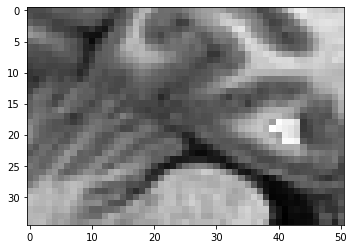

In [4]:
plt.imshow(image[:,:,5] + label[:,:,5]*50, cmap = "gray")
plt.rcParams["figure.figsize"] = (8,8)


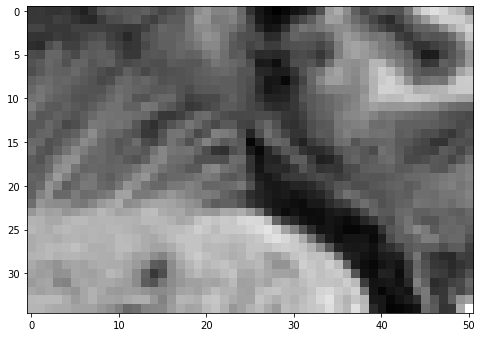

In [5]:
plt.imshow(image[:,:,1] + label[:,:,1]*50, cmap = "gray")
V=plt.rcParams["figure.figsize"] = (8,8)

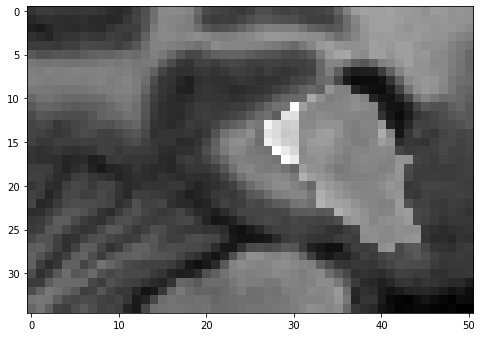

In [6]:
plt.imshow(image[:,:,10] + label[:,:,10]*50, cmap = "gray")
V=plt.rcParams["figure.figsize"] = (8,8)

In [7]:
np.unique(label)

array([0., 1., 2.])

In [8]:
#hippocampus_001.nii was loaded into 3D slicer and a volume of brain tissue was visualized 

Load volume into 3D Slicer to validate that your visualization is correct and get a feel for the shape of structures.Try to get a visualization like the one below (hint: while Slicer documentation is not particularly great, there are plenty of YouTube videos available! Just look it up on YouTube if you are not sure how to do something)

![3D slicer](img/Slicer.png)

In [9]:
# Stand out suggestion: use one of the simple Volume Rendering algorithms that we've
# implemented in one of our earlier lessons to visualize some of these volumes


## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [10]:
# Nibabel supports many imaging formats, NIFTI being just one of them. I told you that our images 
# are in NIFTI, but you should confirm if this is indeed the format that we are dealing with
# TASK: using .header_class attribute - what is the format of our images?
path = r"/data/TrainingSet/images"
images = np.array([[(os.path.join(dp, f), nib.load(os.path.join(dp, f))) for f in files]
                   for dp,_,files in os.walk(path) if len(files) != 0])
print(images[0][0][1])


<class 'nibabel.nifti1.Nifti1Image'>
data shape (35, 55, 37)
affine: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 35 55 37  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.

In [11]:
#total files 
instances = [f for l in images for f in l]
len(instances)


263

In [12]:
path = r"/data/TrainingSet/labels"
labels = np.array([[(os.path.join(dp, f), nib.load(os.path.join(dp, f))) for f in files]
                   for dp,_,files in os.walk(path) if len(files) != 0])


label_instances = [f for l in labels for f in l]
len(label_instances)



262

In [13]:
#total series
len(images)

1

Further down we will be inspecting .header attribute that provides access to NIFTI metadata. You can use this resource as a reference for various fields: https://brainder.org/2012/09/23/the-nifti-file-format/

In [14]:
# TASK: How many bits per pixel are used?
#bitpix = 32, so 32 bits per pixel/voxel
#datatype = float32 indicates bitpix of32

In [15]:
# TASK: What are the units of measurement?
#units of measurement are voxels.   
#for example:pixdim[i] refers to voxel width (number of pixels/voxels) along dimension i.
#To determine the dimensions of the voxels themselves
#we need to know the code for dim info.  Here the code is 0, which means "unknown".

In [16]:
# TASK: Do we have a regular grid? What are grid spacings?
#this is a regular grid because pixdim(1,1,1,1,1,0,0,0)
#and the first three dimensions from left to right are (x,y,z)
#meaning that these voxels are cube shaped, with a volume of 1, and the grid is regular.
#grid spacing is determined by pixdim()

In [17]:
# TASK: What dimensions represent axial, sagittal, and coronal slices? How do you know?
#qform_code and sform_code are scanner based, which means that the x,y,and z are taken as anatomical scanner positions.
#z goes from floor to ceiling, x goes left to right, and y goes front to back.
#if so, then, the sagittal plane is y-z and separates the left from the right
#the coronal plane is x-z and separates the front from the back
#the axial plane is x-y and separates above from below. 


In [18]:
# By now you should have enough information to decide what are dimensions of a single voxel
# TASK: Compute the volume (in mm³) of a hippocampus using one of the labels you've loaded. 
#dim info:0 so the unit of measurement is unknown. 
#dim [ 3 35 55 37  1  1  1  1] where x = 3, y = 35, z = 55
#so, assuming that the unit is cubic mms, 3*35*55 = 4125 cubic mm 
#This makes sense because the size of the hippocampus is a few cm's, not a few meters, not a few mm's. 

# You should get a number between ~2200 and ~4500

In [19]:
for i in range(len(label_instances)):
    print(labels[0][i][1])
 

<class 'nibabel.nifti1.Nifti1Image'>
data shape (35, 55, 37)
affine: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 35 55 37  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
q

## Plotting some charts

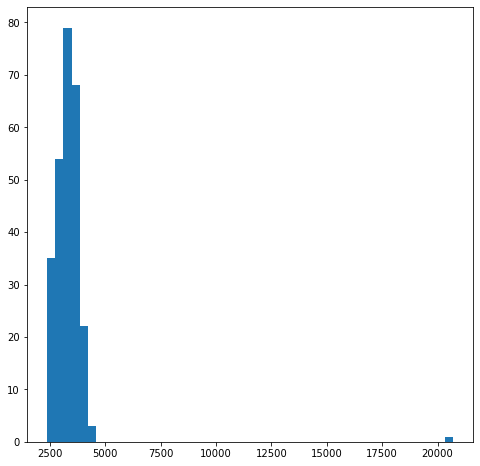

In [20]:
volumes = list()
for i in range(len(label_instances)):
    data = labels[0][i][1].get_fdata()
    volume = np.sum(data > 0)    
    volumes.append(volume)
plt.hist(volumes, 50)
plt.show()

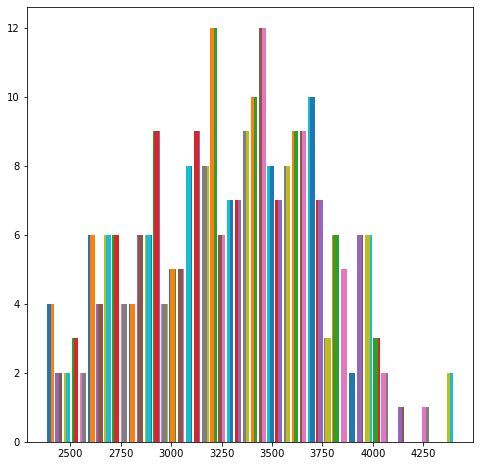

In [21]:
# TASK: Plot a histogram of all volumes that we have in our dataset and see how 
# our dataset measures against a slice of a normal population represented by the chart below.
non_outlier_label = np.array([volume for volume in volumes if (volume < 4500 and volume > 2200)])

volumes = list()
for i in range(len(label_instances)):
    data = labels[0][i][1].get_fdata()
    volume = np.sum(data > 0)    
    volumes.append(non_outlier_label)
plt.hist(volumes, 50)
plt.show()


Do you see any outliers? Why do you think it's so (might be not immediately obvious, but it's always a good idea to inspect) outliers closer. If you haven't found the images that do not belong, the histogram may help you.

In the real world we would have precise information about the ages and conditions of our patients, and understanding how our dataset measures against population norm would be the integral part of clinical validation that we talked about in last lesson. Unfortunately, we do not have this information about this dataset, so we can only guess why it measures the way it is. If you would like to explore further, you can use the [calculator from HippoFit project](http://www.smanohar.com/biobank/calculator.html) to see how our dataset compares against different population slices

Did you notice anything odd about the label files? We hope you did! The mask seems to have two classes, labeled with values `1` and `2` respectively. If you visualized sagittal or axial views, you might have gotten a good guess of what those are. Class 1 is the anterior segment of the hippocampus and class 2 is the posterior one. 

For the purpose of volume calculation we do not care about the distinction, however we will still train our network to differentiate between these two classes and the background

In [23]:
# TASK: Copy the clean dataset to the output folder inside section1/out. You will use it in the next Section
new_volume_labels = nib.Nifti1Image(non_outlier_label, affine = np.eye(4))



In [24]:
nib.save(new_volume_labels, 'section1_outputlabels.nii')


## Final remarks

Congratulations! You have finished Section 1. 

In this section you have inspected a dataset of MRI scans and related segmentations, represented as NIFTI files. We have visualized some slices, and understood the layout of the data. We have inspected file headers to understand what how the image dimensions relate to the physical world and we have understood how to measure our volume. We have then inspected dataset for outliers, and have created a clean set that is ready for consumption by our ML algorithm. 

In the next section you will create training and testing pipelines for a UNet-based machine learning model, run and monitor the execution, and will produce test metrics. This will arm you with all you need to use the model in the clinical context and reason about its performance!